# Peak method applied to NN
The script takes the ECG datasets and for every sample extracts relevant peaks which are then used to train the Neural Network

In [1]:
# Importing packages
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsRegressor
import keras
import keras_tuner as kt
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
# Load data from file and generate training, test and validation sets

DATA_SPLIT = 0.1
SEED = 12345

# Read files
train_df=pd.read_csv('src/mitbih_train.csv',header=None)
test_df=pd.read_csv('src/mitbih_test.csv',header=None)

train_df_x = train_df.iloc[:,:186].values
train_df_y = train_df[187]
x_train, x_test, target_train, target_test = train_test_split(train_df_x, train_df_y, test_size=DATA_SPLIT, random_state=SEED)

y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

num_train = len(y_train)
num_test = len(y_test)


In [3]:
# Train KNN network for different number of neighbors

knn_r_acc = []
for num_neighbors in range(3, 20):

    # Define KNN
    knn_model = KNeighborsRegressor(n_neighbors=num_neighbors)

    # Train KNN model
    knn_model.fit(x_train, y_train)

    # Extract trained model scores
    train_score = knn_model.score(x_train,y_train)
    test_score = knn_model.score(x_test,y_test)
    knn_r_acc.append((num_neighbors, test_score ,train_score))

# Print results
df = pd.DataFrame(knn_r_acc, columns=['K','Test Score','Train Score'])
print(df)


     K  Test Score  Train Score
0    3    0.784120     0.903849
1    4    0.788346     0.883752
2    5    0.785270     0.869251
3    6    0.782037     0.857141
4    7    0.781152     0.847405
5    8    0.775007     0.839027
6    9    0.771242     0.830971
7   10    0.765896     0.824527
8   11    0.764168     0.817941
9   12    0.761722     0.812988
10  13    0.758812     0.807945
11  14    0.756247     0.803636
12  15    0.753874     0.799205
13  16    0.751658     0.795307
14  17    0.748242     0.791357
15  18    0.745489     0.788013
16  19    0.743943     0.784569


In [4]:
# Consider only best model
BEST_KNN = 3

knn_model_best = KNeighborsRegressor(n_neighbors=BEST_KNN)
knn_model_best.fit(x_train, y_train)

y_prediction = knn_model_best.predict(x_test)
y_prediction = np.argmax(y_prediction, axis = 1)
y_test_pred = np.argmax(y_test, axis=1)

# Create confusion matrix and normalize it over predicted (columns)
result = confusion_matrix(y_test_pred, y_prediction , normalize='pred')
#result = confusion_matrix(y_test_pred, y_prediction , normalize='true')
#result = confusion_matrix(y_test_pred, y_prediction , normalize='all')
#result = confusion_matrix(y_test_pred, y_prediction)
classes = [0,1,2,3,4]
result_norm = np.around(result, 3)
#result_norm = result
mat_result = pd.DataFrame(result_norm,
                     index = classes, 
                     columns = classes)

total_pred = np.trace(result) / 5

print('Confusion matrix')
print(mat_result)
print()
print('Average accuracy')
print(total_pred)

Confusion matrix
       0      1      2      3      4
0  0.980  0.143  0.035  0.000  0.009
1  0.009  0.850  0.005  0.000  0.000
2  0.006  0.007  0.942  0.122  0.002
3  0.002  0.000  0.007  0.878  0.000
4  0.003  0.000  0.011  0.000  0.989

Average accuracy
0.9277891522640342


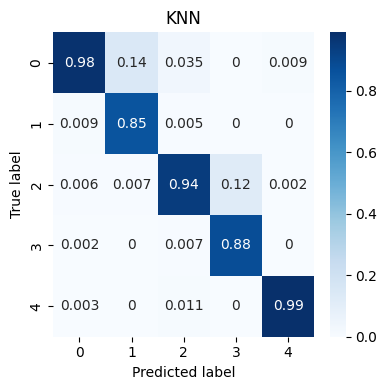

In [5]:
figure = plt.figure(figsize=(4, 4))
sns.heatmap(mat_result, annot=True,cmap=plt.cm.Blues)
plt.title("KNN")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()